In [1]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
class ImageProcessor:
    def __init__(self,path,imageSize=512):
        self.path = path
        self.imageSize = imageSize
        self.originalImage = self.resizeImage(self.path, self.imageSize)
        self.bglessImage = None
        self.alphaOnly = None

    #Resize image to specifed size for further processing
    @staticmethod
    def resizeImage(image_path,size):
        resize = transforms.Resize((size, size))
        imageInput = Image.open(image_path).convert("RGB")
        return resize(imageInput)        

    #Remove background of the input image
    def removeBackground(self):
        imageInput = self.originalImage
        imageOutput = remove(imageInput)
        self.bglessImage = imageOutput

    #Extract the transparency from the backgroundlessImage
    def extractAlpha(self):
        if self.bglessImage != None:
            rgbaImg = np.array(self.bglessImage.convert("RGBA")) #Convert to 4 channel image
            alpha = rgbaImg[:,:,3] # Extract alpha channel
            normalisedAlpha = alpha / 255.0 #normalise to 0-1
            self.alphaOnly = normalisedAlpha
        else:
            print("No backgroundless image available")

    #Display available image
    def displayImages(self):
        imgs = [self.originalImage, self.bglessImage, self.alphaOnly]
        titles = ["Original", "Background Removed", "Alpha Only"]
        validImg = [(img,title) for img, title in zip(imgs, titles) if img is not None]
        count = len(validImg)
        plt.figure(figsize=(count*4,count*2))
        for i,(img, title) in enumerate(validImg):
            plt.subplot(1,count,i+1)
            plt.imshow(img, cmap = "grey" if "Alpha Only"== title else None) #set grey cmap for alpha image
            plt.title(title)
            plt.axis("off")
        plt.show()

    def alphaOutput(self, inverse = False):
        alpha = self.alphaOnly
        if inverse :
            alpha = 1.0 - alpha
        return alpha

    def resizedImage(self):
        return self.originalImage
        

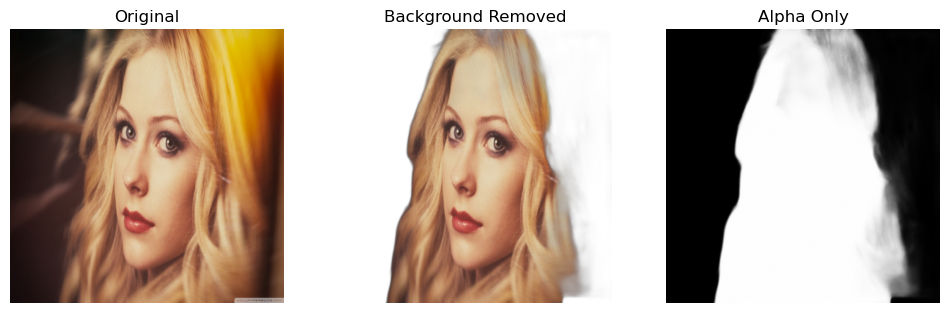

In [3]:
image_path = "content/avril.jpg"

imgPro = ImageProcessor(image_path)
imgPro.removeBackground()
imgPro.extractAlpha()
imgPro.displayImages()

In [4]:
#implementation based on https://github.com/naoto0804/pytorch-AdaIN

class AdaIN:
    def __init__(self, content_path, style_paths, prebuild_encoder = None, prebuild_decoder = None):
        self.content_path = content_path
        self.style_paths = style_paths #Tuple
        self.encoder = self.__vgg()
        self.decoder = self.__vggDecoder()
        self.prebuild_encoder = prebuild_encoder
        self.prebuild_decoder = prebuild_decoder
        self.content = None
        self.styles = ()
        self.stylisedImage = None

    #Encoder by nato0804
    def __vgg(self):
        return nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(), 
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  
        )

    #Decoder by nato0804
    def __vggDecoder(self):
        return nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
        )

    #Adain implementation by nato0804
    #Calcualte mean and variance
    def __calc_mean_std(self, feat, eps=1e-5):
        N, C = feat.size()[:2]
        feat_ = feat.view(N, C, -1)
        mean = feat_.mean(dim=2).view(N, C, 1, 1)
        std = feat_.var(dim=2).add(eps).sqrt().view(N, C, 1, 1)
        return mean, std

    #Matching style with features 
    def __adain(self, content_feat, style_feat, alpha=1.0):
        c_mean, c_std = self.__calc_mean_std(content_feat)
        s_mean, s_std = self.__calc_mean_std(style_feat)
        normalized = (content_feat - c_mean) / c_std
        stylized = normalized * s_std + s_mean
        return alpha * stylized + (1 - alpha) * content_feat

    #Pre-processing of image
    def processor(self, addDimension = 0):
        tensorise = transforms.ToTensor()
        #Load content
        self.content = ImageProcessor(self.content_path)

        #Clear stored styles to avoid duplication
        self.styles = ()
        
        #Load styles
        for style in self.style_paths:
            self.styles += (ImageProcessor(style),)

        content = self.content
        styles = self.styles

        #Convert to tensor
        content = tensorise(content.resizedImage())
        styles = tuple(tensorise(s.resizedImage()) for s in styles)

        #add dimension
        for i in range(addDimension):
            content = content.unsqueeze(0)
            styles = tuple(s.unsqueeze(0) for s in styles)

        return content, styles


    def encodeAll (self, content, styles):
        #Enocde content and styles
        contentFeature = self.encoder(content)
        styleFeatures = tuple(self.encoder(s) for s in styles)
        return contentFeature, styleFeatures

        
    def stylisation(self, contentFeature, styleFeatures, alpha = 1.0):
        adaINOut = self.__adain(contentFeature, styleFeatures[0], alpha) #Handle 1 style currently
        return adaINOut

    def decoding(self, adainOutput):
        #Decode output
        decodedOutput = self.decoder(adainOutput)
        #Convert back to image - remove tensor, convert to numpy, and restructure
        self.stylisedImage = decodedOutput.detach().clamp(0,1).squeeze(0).permute(1,2,0).numpy()
        return self.stylisedImage
        
    def spatialControl(self, content, styles, foreground_style_index = None, background_style_index = None):
        #Remove background and alpha
        self.content.removeBackground()
        self.content.extractAlpha()
        dimension = content.dim()

        #tensorise mask
        foreMask = torch.tensor(self.content.alphaOutput(), dtype=torch.float32)

        #Add dimension if insufficient
        while foreMask.dim() < content.dim():
            foreMask = foreMask.unsqueeze(0)
        
        #Mask for style and content
        foreStyle = (styles[foreground_style_index]) if foreground_style_index != None else None
        backStyle = (styles[background_style_index]) if background_style_index != None else None

        #Extract Features
        contentFeature = self.encoder(content)
        foreFeatureStyle = self.encoder(foreStyle) if foreground_style_index != None else None
        backFeatureStyle = self.encoder(backStyle) if background_style_index != None else None

        #Apply Adain
        styledForeground = self.stylisation(contentFeature, [foreFeatureStyle]) if foreFeatureStyle != None else contentFeature
        styledBackground = self.stylisation(contentFeature, [backFeatureStyle]) if backFeatureStyle != None else contentFeature

        #Resize mask
        d1,d2,h,w = contentFeature.shape
        foreMaskFeature = nn.functional.interpolate(foreMask, size=(h,w), mode="bilinear", align_corners=False)
        backMaskFeature = 1 - foreMaskFeature

        #Combine - prevent leak using masks
        combinedFeature = foreMaskFeature * styledForeground + backMaskFeature * styledBackground

        self.decoding(combinedFeature)


    #Display available image
    def displayImages(self):
        content = self.content.resizedImage()
        styles = [s.resizedImage() for s in self.styles]
        stylised = self.stylisedImage

        #Create title 
        titles = (["Content"]+ [f"Style {i+1}" for i in range(len(styles))] + ["Stylised"])

        #Combine as list
        imgs = [content] + styles + [stylised] 

        #filter out None image
        validImg = [(img,title) for img, title in zip(imgs, titles) if img is not None]

        count = len(validImg)

        #Display image
        plt.figure(figsize=(count*4,count*2))
        for i,(img, title) in enumerate(validImg):
            plt.subplot(1,count,i+1)
            plt.imshow(img)
            plt.title(title)
            plt.axis("off")
        plt.show()
               
    
    #Load prebuild model
    def loadPrebuildEncoder(self, layers = None):
        eState = torch.load(self.prebuild_encoder, map_location="cpu")
        self.encoder.load_state_dict(eState)
        if layers != None: #slice layer if applied
            self.encoder = nn.Sequential(*list(self.encoder.children())[:layers])
        
        
    def loadPrebuildDecoder(self, layers = None):
        eState = torch.load(self.prebuild_decoder, map_location="cpu")
        self.decoder.load_state_dict(eState)
        if layers != None:
            self.decoder = nn.Sequential(*list(self.decoder.children())[:layers])
        
    #helper tool to evaluate encoder/decoder
    def evalEncoder(self):
        self.encoder.eval()
        
    def evalDecoder(self):
        self.decoder.eval()

    #helper tool to unload non-default encoder/decoder
    def uploadEncoder(self, input):
        self.encoder = input
        
    def uploadDecoder(self, input):
        self.decoder = input

In [5]:
style_path = "style/sketch.png"
prebuildEnocder = "vgg.pth"
prebuildDecoder = "decoder-adain.pth"


adainModel = AdaIN(image_path,(style_path,), prebuildEnocder, prebuildDecoder )

In [6]:
adainModel.loadPrebuildEncoder(31)
adainModel.loadPrebuildDecoder()


In [7]:
c,s = adainModel.processor(1)
c1,s1 = adainModel.encodeAll(c,s)
out = adainModel.stylisation(c1,s1)
adainModel.decoding(out)

array([[[0.65299696, 0.6647822 , 0.6747832 ],
        [0.64878196, 0.6619312 , 0.6732512 ],
        [0.6511678 , 0.66413754, 0.674905  ],
        ...,
        [0.68075085, 0.6906213 , 0.6535667 ],
        [0.7004197 , 0.71166486, 0.6773868 ],
        [0.69616205, 0.7068874 , 0.6734916 ]],

       [[0.673696  , 0.6925385 , 0.6941461 ],
        [0.6668082 , 0.6879324 , 0.69123596],
        [0.6766299 , 0.69824183, 0.6989045 ],
        ...,
        [0.6797816 , 0.68703586, 0.64851296],
        [0.70123535, 0.70883733, 0.6727096 ],
        [0.697698  , 0.70640475, 0.66978663]],

       [[0.67299634, 0.69194496, 0.6967369 ],
        [0.6643984 , 0.6852911 , 0.6863116 ],
        [0.67646587, 0.6964079 , 0.69883907],
        ...,
        [0.6709868 , 0.6804321 , 0.6461614 ],
        [0.6905403 , 0.69893116, 0.66988724],
        [0.6851351 , 0.69565594, 0.6633498 ]],

       ...,

       [[0.6688656 , 0.670431  , 0.684546  ],
        [0.6994921 , 0.69217044, 0.70083785],
        [0.72631025, 0

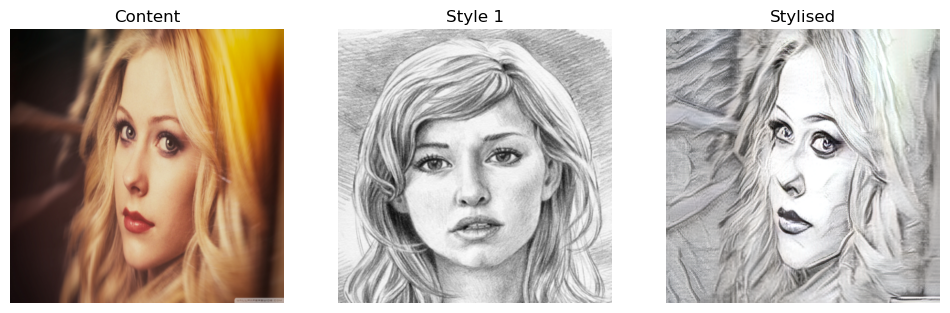

In [8]:
adainModel.displayImages()

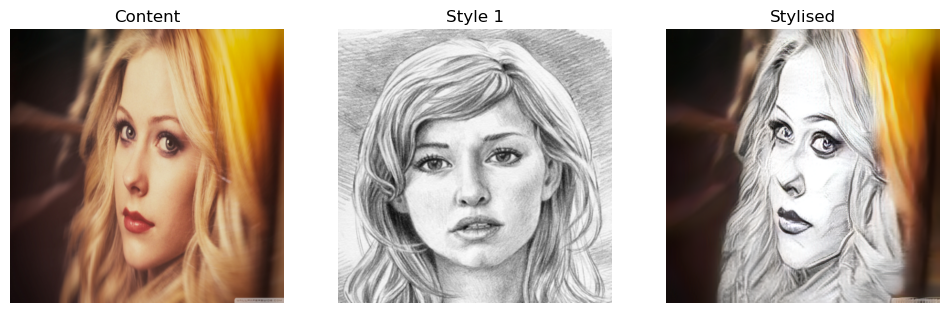

In [9]:
c,s = adainModel.processor(1)
adainModel.spatialControl(c,s, foreground_style_index = 0)
adainModel.displayImages()

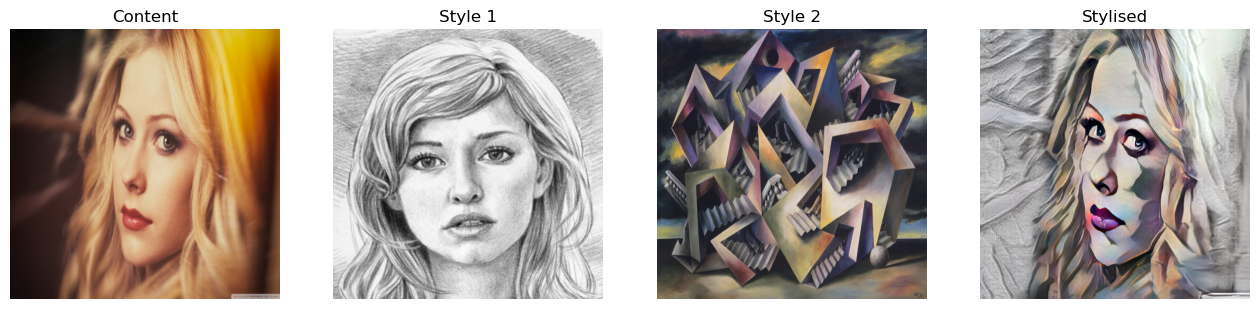

In [11]:
style2_path = "style/trial.jpg"
adainModel2 = AdaIN(image_path,(style_path,style2_path), prebuildEnocder, prebuildDecoder )
adainModel2.loadPrebuildEncoder(31)
adainModel2.loadPrebuildDecoder()
c,s = adainModel2.processor(1)
adainModel2.spatialControl(c,s, foreground_style_index = 1, background_style_index = 0)
adainModel2.displayImages()